# Matrix Factorization with NN (1. Experiments)

* See [0_Problem.ipynb](0_Problem.ipynb) for problem background.
* Pack model into a class for easy resue and try on larger matrices 
* Experiment on two matrix cases 
    1. $M$ is random matrix, 
    2. $M$ is a product of two random matrices $M = M_1 M_2$ (hence not completely random). 
* Experiment with the length of the latent vector (the number of NN in the hiddent layer). It changes the capacity of the model (number of free parameters).

In [1]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf

print(tf.__version__)
np.set_printoptions(precision=4, suppress=True)

1.10.0


## Model 

* Add batchsize to accomodate larger matrices. Also shuffule between epochs.

In [2]:
# input matrix_shape

class MatrixFactoriztionNN():
    
    def __init__(self, matrix, hidden_size):
        self.matrix = matrix
        num_row = matrix.shape[0];
        num_col = matrix.shape[1];
        
        self.x = tf.placeholder(tf.float32, [None, num_row], name='x') # input a 1-of-num_column vector
        self.y = tf.placeholder(tf.float32, [None, num_col], name='y') # output the activated row vector

        self.W1 = tf.Variable(tf.random_normal([num_row, hidden_size]))
        l1 = tf.matmul(self.x, self.W1)
        self.W2 = tf.Variable(tf.random_normal([hidden_size, num_col]))
        self.pred = tf.matmul(l1, self.W2)
    

    def solve(self, optimizer=tf.train.AdamOptimizer(), rmse_tolerance = None, max_epoch = 10000, batch_size=None, verbose=True): 
        (x, y, pred) = (self.x, self.y, self.pred)
        loss = tf.reduce_mean(tf.square(self.pred - self.y)) # mse of the activated row
        matrix_pred = tf.matmul(self.W1, self.W2)
        matrix_mse = tf.reduce_mean(tf.square(matrix_pred - self.matrix)) # mse of whole matrix
        matrix_rmse = tf.sqrt(matrix_mse)
        
#         optimize_step = optimizer.minimize(loss) 
        optimize_step = optimizer.minimize(matrix_mse) 
        
        # Form data and batching
        (num_row, num_col) = self.matrix.shape        
        if batch_size is None:
            batch_size = num_row
        x_data = np.eye(num_row) # 1-of-num_row vectors
        y_data = self.matrix
        row_index = np.arange(self.matrix.shape[0])
        feed_dict = {x: x_data, y:y_data}
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(max_epoch):
                np.random.shuffle(row_index) # shuffle (in place) every epoch 
                for i_batch in range(int(np.ceil(num_row/batch_size))):
                    row = row_index[i_batch*batch_size:(i_batch+1)*batch_size]
                    feed_dict = {x:x_data[row,:], y:y_data[row,:]}                   
                    o_pred, o_loss, o_matrix_rmse = sess.run([pred, loss, matrix_rmse], feed_dict)
                    if verbose:
                        if epoch % 2000 == 0:
                            print('Epoch: {}  loss: {:.5e}  matrix_rmse: {:.5e}'.format(epoch, o_loss, o_matrix_rmse))
                            
                    sess.run(optimize_step, feed_dict)
                if rmse_tolerance is not None:
                    if o_matrix_rmse < rmse_tolerance: 
                        print('Desired tolerance reached, stopping early')
                        break
                    
            # done
            result = sess.run([self.W1, self.W2, matrix_rmse])
            if verbose:
                print('W1\n', result[0])
                print('W2\n', result[1])
                print('matrix rmse: {:.5e}'.format(o_matrix_rmse))
        return result


## Matrix Generator 

* Generate random matrix $M$. 
    * Beware that it returns intrinsically random $M$ (not $M=M_1M_2$ in the previous notebook).
* Note: The `keep_prob` input allow one to set a protion of matrix element to 0. The intention was to mimic a sparse matrix, but this is not explored in this notebook (and this is not realistic anyway).

In [3]:
def mat_gen(shape, keep_prob=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mat = np.random.random(shape)
    if keep_prob is not None:
        mask = np.random.choice([True, False], size = shape, p = [keep_prob, 1-keep_prob])
        mat = mat * mask
    return mat

## Quick Check

### M[2x4], vector dimension 3 

* Result: can reach very small rmse. The algorithm can work. 


In [4]:
# Set dimension of M and the size of hidden layer
# ------
num_row = 2
num_col = 4
hidden_size = 3 # The size (number of NN) of the hidden layer, also correspondes to the intended vector size to be learned  
# ------

M = mat_gen([num_row, num_col], keep_prob=1., seed=0)
print('M:\n', M)

# solve
batch_size = None
model = MatrixFactoriztionNN(M, hidden_size) 
[W1, W2, rmse] = model.solve(max_epoch = 30000, rmse_tolerance=1e-10, batch_size=batch_size)
print('M:\n', M)
print('W1W2:\n', np.matmul(W1, W2))

M:
 [[0.5488 0.7152 0.6028 0.5449]
 [0.4237 0.6459 0.4376 0.8918]]
Epoch: 0  loss: 4.73433e+00  matrix_rmse: 2.17585e+00
Epoch: 2000  loss: 1.04352e-02  matrix_rmse: 1.02153e-01
Epoch: 4000  loss: 9.61868e-03  matrix_rmse: 9.80749e-02
Epoch: 6000  loss: 9.30671e-03  matrix_rmse: 9.64713e-02
Epoch: 8000  loss: 2.05144e-05  matrix_rmse: 4.52928e-03
Epoch: 10000  loss: 1.31117e-13  matrix_rmse: 3.62101e-07
Epoch: 12000  loss: 1.25455e-14  matrix_rmse: 1.12007e-07
Epoch: 14000  loss: 1.69864e-14  matrix_rmse: 1.30332e-07
Epoch: 16000  loss: 1.41027e-09  matrix_rmse: 3.75535e-05
Epoch: 18000  loss: 1.61422e-08  matrix_rmse: 1.27052e-04
Epoch: 20000  loss: 1.42772e-10  matrix_rmse: 1.19487e-05
Epoch: 22000  loss: 9.24816e-14  matrix_rmse: 3.04108e-07
Epoch: 24000  loss: 7.92980e-09  matrix_rmse: 8.90494e-05
Epoch: 26000  loss: 1.28567e-08  matrix_rmse: 1.13387e-04
Epoch: 28000  loss: 7.09022e-10  matrix_rmse: 2.66275e-05
W1
 [[ 0.9695 -0.8923 -0.7954]
 [ 1.1775 -1.7275 -0.6895]]
W2
 [[-1.727

### Slightly larger matrix [4x8] / vector dimension 3

* Result: Stucked at a much higher rmse of ~1e-2

In [5]:
# ------
num_row = 4
num_col = 8
hidden_size = 3
# ------

M = mat_gen([num_row, num_col], keep_prob=1., seed=0)
print('M:\n', M)

# solve
batch_size = None
model = MatrixFactoriztionNN(M, hidden_size) 
[W1, W2, rmse] = model.solve(max_epoch = 30000, rmse_tolerance=1e-10, batch_size=batch_size)
print('M:\n', M)
print('W1W2:\n', np.matmul(W1, W2))

M:
 [[0.5488 0.7152 0.6028 0.5449 0.4237 0.6459 0.4376 0.8918]
 [0.9637 0.3834 0.7917 0.5289 0.568  0.9256 0.071  0.0871]
 [0.0202 0.8326 0.7782 0.87   0.9786 0.7992 0.4615 0.7805]
 [0.1183 0.6399 0.1434 0.9447 0.5218 0.4147 0.2646 0.7742]]
Epoch: 0  loss: 2.28214e+00  matrix_rmse: 1.51068e+00
Epoch: 2000  loss: 3.77897e-02  matrix_rmse: 1.94396e-01
Epoch: 4000  loss: 1.41602e-02  matrix_rmse: 1.18997e-01
Epoch: 6000  loss: 7.51976e-03  matrix_rmse: 8.67165e-02
Epoch: 8000  loss: 5.77189e-03  matrix_rmse: 7.59730e-02
Epoch: 10000  loss: 5.67451e-03  matrix_rmse: 7.53293e-02
Epoch: 12000  loss: 5.67430e-03  matrix_rmse: 7.53279e-02
Epoch: 14000  loss: 5.67430e-03  matrix_rmse: 7.53280e-02
Epoch: 16000  loss: 5.67430e-03  matrix_rmse: 7.53280e-02
Epoch: 18000  loss: 5.67430e-03  matrix_rmse: 7.53280e-02
Epoch: 20000  loss: 5.67430e-03  matrix_rmse: 7.53280e-02
Epoch: 22000  loss: 5.67442e-03  matrix_rmse: 7.53288e-02
Epoch: 24000  loss: 5.67430e-03  matrix_rmse: 7.53279e-02
Epoch: 26000 

### Slightly larger matrix [4x8] / vector dimension 6 

* Result: relatively better rmse than the previous one ~1e-4
* The increased model capacity (more free parameters) can fit the matrix better. 

In [6]:
# ------
num_row = 4
num_col = 8
hidden_size = 6
# ------

M = mat_gen([num_row, num_col], keep_prob=1., seed=0)
print('M:\n', M)

# solve
batch_size = None
model = MatrixFactoriztionNN(M, hidden_size) 
[W1, W2, rmse] = model.solve(max_epoch = 30000, rmse_tolerance=1e-10, batch_size=batch_size)
print('M:\n', M)
print('W1W2:\n', np.matmul(W1, W2))

M:
 [[0.5488 0.7152 0.6028 0.5449 0.4237 0.6459 0.4376 0.8918]
 [0.9637 0.3834 0.7917 0.5289 0.568  0.9256 0.071  0.0871]
 [0.0202 0.8326 0.7782 0.87   0.9786 0.7992 0.4615 0.7805]
 [0.1183 0.6399 0.1434 0.9447 0.5218 0.4147 0.2646 0.7742]]
Epoch: 0  loss: 4.20949e+00  matrix_rmse: 2.05170e+00
Epoch: 2000  loss: 7.38307e-03  matrix_rmse: 8.59248e-02
Epoch: 4000  loss: 1.53214e-03  matrix_rmse: 3.91425e-02
Epoch: 6000  loss: 3.37501e-04  matrix_rmse: 1.83712e-02
Epoch: 8000  loss: 2.13333e-05  matrix_rmse: 4.61880e-03
Epoch: 10000  loss: 4.79677e-08  matrix_rmse: 2.19015e-04
Epoch: 12000  loss: 1.50860e-13  matrix_rmse: 3.88407e-07
Epoch: 14000  loss: 2.08570e-12  matrix_rmse: 1.44420e-06
Epoch: 16000  loss: 4.39027e-10  matrix_rmse: 2.09530e-05
Epoch: 18000  loss: 5.77975e-11  matrix_rmse: 7.60246e-06
Epoch: 20000  loss: 1.50767e-08  matrix_rmse: 1.22787e-04
Epoch: 22000  loss: 4.94168e-10  matrix_rmse: 2.22299e-05
Epoch: 24000  loss: 2.07211e-10  matrix_rmse: 1.43948e-05
Epoch: 26000 

## Systemetic Exploration Using larger matrix [40x80] 

### A. Random matrix $M$ [40x80]

* Realize that the model capacity is critical, because the data $M$ is **RANDOM**, and there are no latent features to learn. In other words, the pixels are all independent, so there's no way to dig out any hidden structure from the noise. 
* In the case of 40x80 matrix, ~26 hidden units should give enough free parameters (40\*80 ~= 40\*26 + 80\*26). 
* Below we test different values between about 2~50

In [7]:
# The list of different vector lengths to try
h_list = np.append([2, 3, 4], np.arange(5, 55, 5))
print(h_list)

[ 2  3  4  5 10 15 20 25 30 35 40 45 50]


In [8]:
# ------
num_row = 40
num_col = 80
# ------

M = mat_gen([num_row, num_col], keep_prob=1., seed=0)
print('M:\n', M)

rmse_A = []
for hidden_size in h_list:
    model = MatrixFactoriztionNN(M, hidden_size) 
    [W1, W2, rmse] = model.solve(max_epoch = 30000, rmse_tolerance=1e-10, verbose=False)
    print('Case ' + str(hidden_size)+ ' rmse: ', rmse)
    rmse_A.append(rmse)


M:
 [[0.5488 0.7152 0.6028 ... 0.1202 0.2961 0.1187]
 [0.318  0.4143 0.0641 ... 0.5691 0.4072 0.0692]
 [0.6974 0.4535 0.7221 ... 0.4636 0.2776 0.5868]
 ...
 [0.238  0.9016 0.5085 ... 0.0598 0.3022 0.6772]
 [0.5779 0.3307 0.8335 ... 0.5956 0.8253 0.2738]
 [0.9175 0.7577 0.0613 ... 0.6341 0.5777 0.6019]]
Case 2 rmse:  0.2763079
Case 3 rmse:  0.26690912
Case 4 rmse:  0.25790924
Case 5 rmse:  0.24908374
Case 10 rmse:  0.20855233
Case 15 rmse:  0.17081974
Case 20 rmse:  0.13491172
Case 25 rmse:  0.10220961
Case 30 rmse:  0.07192991
Case 35 rmse:  0.0418689
Case 40 rmse:  0.0011975422
Case 45 rmse:  0.00078521715
Case 50 rmse:  0.0006333966


### B. Partially Random $M$ [40x80] ($=M_1M_2$) 

* See if we generate M as the product of two random matrices will be easier to learn
* The key is that in this case, the pixels in $M$ will not be completely independent. **There is a hidden structure**

#### B1. $M_1$[40x3] $M_2$[3x80]) 

* num_intermediate = **3**


In [9]:
# ------
num_row = 40
num_col = 80
# ------

num_intermediate = 3 # fixed

M1 = mat_gen([num_row, num_intermediate], keep_prob=1., seed=0) 
M2 = mat_gen([num_intermediate, num_col], keep_prob=1., seed=0)
M = np.matmul(M1, M2)
print('M:\n', M)

rmse_B1 = []
for hidden_size in h_list:
    model = MatrixFactoriztionNN(M, hidden_size) 
    [W1, W2, rmse] = model.solve(max_epoch = 30000, rmse_tolerance=1e-10, verbose=False)
    print('Case ' + str(hidden_size)+ ' rmse: ', rmse)
    rmse_B1.append(rmse)


M:
 [[0.949  0.9622 0.8119 ... 0.7524 0.6211 0.4683]
 [0.8842 0.8581 0.822  ... 0.606  0.5132 0.473 ]
 [1.1958 1.1194 1.0168 ... 1.0068 0.7602 0.6791]
 ...
 [0.8944 1.03   0.7698 ... 0.6377 0.618  0.3234]
 [1.1872 1.1459 1.1522 ... 0.7319 0.6471 0.6411]
 [1.0824 1.0951 0.907  ... 0.8927 0.7234 0.5364]]
Case 2 rmse:  0.07173282
Case 3 rmse:  3.834189e-05
Case 4 rmse:  9.944749e-06
Case 5 rmse:  7.0258844e-05
Case 10 rmse:  0.00035064327
Case 15 rmse:  9.616461e-05
Case 20 rmse:  0.0001265474
Case 25 rmse:  0.00018341745
Case 30 rmse:  0.00023653844
Case 35 rmse:  0.00015789867
Case 40 rmse:  0.00050836353
Case 45 rmse:  0.00027998685
Case 50 rmse:  0.000731268


#### B2. $M_1$[40x15] $M_2$[15x80]) 

* num_intermediate = **15**


In [10]:
# ------
num_row = 40
num_col = 80
# ------

num_intermediate = 15 # fixed

M1 = mat_gen([num_row, num_intermediate], keep_prob=1., seed=0) 
M2 = mat_gen([num_intermediate, num_col], keep_prob=1., seed=0)
M = np.matmul(M1, M2)
print('M:\n', M)

rmse_B2 = []
for hidden_size in h_list:
    model = MatrixFactoriztionNN(M, hidden_size) 
    [W1, W2, rmse] = model.solve(max_epoch = 30000, rmse_tolerance=1e-10, verbose=False)
    print('Case ' + str(hidden_size)+ ' rmse: ', rmse)
    rmse_B2.append(rmse)

M:
 [[4.1936 4.5539 4.4221 ... 3.472  5.0589 5.3585]
 [3.669  4.2571 3.7241 ... 3.6089 4.3039 5.0734]
 [4.054  4.5153 3.6977 ... 3.3211 3.7281 4.4523]
 ...
 [4.4549 4.9721 4.8969 ... 3.4995 4.6862 5.6439]
 [3.9524 3.8125 3.5403 ... 2.397  2.8402 3.677 ]
 [2.9443 4.1554 3.5248 ... 2.9124 3.7706 4.4722]]
Case 2 rmse:  0.28085107
Case 3 rmse:  0.2542333
Case 4 rmse:  0.23003101
Case 5 rmse:  0.20532255
Case 10 rmse:  0.10839217
Case 15 rmse:  0.00024200075
Case 20 rmse:  0.00012411113
Case 25 rmse:  3.5607172e-05
Case 30 rmse:  0.0014120609
Case 35 rmse:  0.0010170764
Case 40 rmse:  0.0005936978
Case 45 rmse:  0.00085893035
Case 50 rmse:  0.0007234091


## RMSE as  a function of latent vector length

* The plot shows that:
    * A. completely random M takes larger than ~>35 hidden unit to fit.
    * B1. M generated n_intermediate = 3 (less random) only needs a small hidden layer to fit (~> 3)
    * B2. M generated n_intermediate = 15 (more random) needs more hidden layer to fit (~> 15)

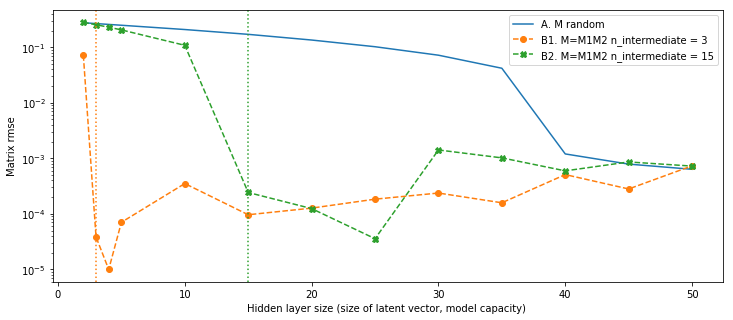

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12, 5])
plt.semilogy(h_list, rmse_A, '-', label='A. M random')
h_B1 = plt.semilogy(h_list, rmse_B1, '--o', label='B1. M=M1M2 n_intermediate = 3')
h_B2 = plt.semilogy(h_list, rmse_B2, '--X', label='B2. M=M1M2 n_intermediate = 15')
plt.axvline(x=3, color=h_B1[0].get_color(), linestyle=':')
plt.axvline(x=15, color=h_B2[0].get_color(), linestyle=':')
plt.ylabel('Matrix rmse')
plt.xlabel('Hidden layer size (size of latent vector, model capacity) ')
plt.legend()
plt.show()

## Summary

1. Whether there are hidden sstructures or not affects how large the model need to be for the factorization to work.
    1. For completely random $M$, the model will need sufficiently large capacity to reproduce each element because they are all independent, and there's no hidden structure to be learned.
    2. For $M = M_1 M_2$ (so $M$ is not a complete random matrix), the dimension of freedom has to do with the intermediate dimension. This shows that the latent structures are indeed learned, so you do not need as much parameters to describe the data. 


## Note

While interesting, this is actually not how matrix factorization workk in a recommendataion system. In a reallistic problem the data matrix is likely sparse, with the emptiness representing the lack of data rather than true zeros. So what we really want to do is to train on the availale matrix elements and learn latent vectors that can be used to predict these missiing spots. (See, for example, the explanation in [this post](http://www.albertauyeung.com/post/python-matrix-factorization/))
